# Isotopically Non-Stationary 13C-MFA
INCA is capable of analyzing isotopically non-stationary (INST) data. I such data sets the fluxes are still assumed to be constant, however the isotopologue distribution vector are allow to vary dynamically (See plot further down).

The INCAWrapper can setup INCA models to fit INST datasets. In this example we will show how by estimating the flux distribution from a simulated INST dataset.

The simulated dataset is produced using the simple model [1,2], which we have also used in earlier tutorials. This time however, we simulated the isotopically non-stationary data. To inspect how the data was simulated see https://github.com/biosustain/incawrapper/tree/main/docs/examples/Literature%20data/simple%20model/simple_model_inst_simulation.py.

In [1]:
import pandas as pd
import pathlib
import incawrapper
import ast
PROJECT_DIR = pathlib.Path().cwd().parents[1].resolve()
data_folder = PROJECT_DIR / pathlib.Path("docs/examples/Literature data/simple model")

To fit fluxes to a INST dataset INCA as minimum requires:

- Reaction data
- Tracer data
- MS measurements

Furthermore, it is possible to use 
- Flux measurements
- Pool size measurement, i.e. concentrations of metabolites

For completeness, we will here consider the data where we have ms, pool size, and flux measurements. We will load both the measurements and the tracer and reaction information here.

In [2]:
tracers_data = pd.read_csv(data_folder / "tracers.csv", 
   converters={'atom_mdv':ast.literal_eval, 'atom_ids':ast.literal_eval} # a trick to read lists from csv
).query("experiment_id == 'exp1'") # we only simulated experiment 1

reactions_data = pd.read_csv(data_folder / "reactions.csv")
ms_data = pd.read_csv(data_folder / 'simulated_data' / "mdv_no_noise.csv", 
   converters={'labelled_atom_ids': ast.literal_eval} # a trick to read lists from csv
)
pool_sizes = pd.read_csv(data_folder / 'simulated_data' / "pool_sizes_measurement_no_noise.csv")
flux_measurements = pd.read_csv(data_folder / 'simulated_data' / "flux_measurements_no_noise.csv")

The toy model has 5 reactions that we will show here.

In [3]:
reactions_data.head()

,model,rxn_id,rxn_eqn
0,simple_model,R1,A (abc) -> B (abc)
1,simple_model,R2,B (abc) <-> D (abc)
2,simple_model,R3,B (abc) -> C (bc) + E (a)
3,simple_model,R4,B (abc) + C (de) -> D (bcd) + E (a) + E (e)
4,simple_model,R5,D (abc) -> F (abc)


We consider one experiment with a single labelled substrate, A, which is labelled at carbon position 2.

In [4]:
tracers_data.head()

,experiment_id,met_id,tracer_id,atom_ids,ratio,atom_mdv,enrichment
0,exp1,A,[2-13C]A,[2],1.0,"[0, 1]",1


When analysing INST data, we have mass distribution vectors of the same metabolite at multiple time points. These are specified by adding the timepoint in the `time` column.

In [5]:
ms_data.head()

,experiment_id,met_id,ms_id,measurement_replicate,labelled_atom_ids,unlabelled_atoms,mass_isotope,intensity_std_error,time,intensity
0,exp1,B,B1,1,"[1, 2, 3]",NaN,0,0.003,0,1.0
1,exp1,B,B1,1,"[1, 2, 3]",NaN,1,0.003,0,0.0
2,exp1,B,B1,1,"[1, 2, 3]",NaN,2,0.003,0,0.0
3,exp1,B,B1,1,"[1, 2, 3]",NaN,3,0.003,0,0.0
4,exp1,F,F1,1,"[1, 2, 3]",NaN,0,0.003,0,1.0


To get a better idea of what the data looks like we can visualise the time series.

/Users/s143838/.virtualenvs/incawrapper-dev/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


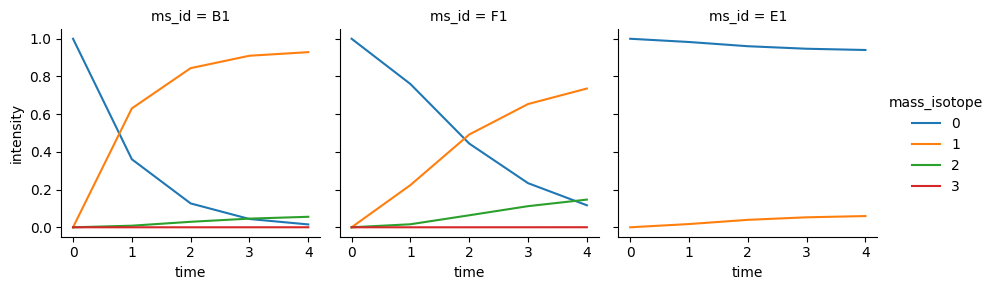

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(ms_data, col="ms_id", hue="mass_isotope")
g.map_dataframe(sns.lineplot, data=ms_data, x="time", y="intensity")

# add overall legend
g.add_legend()

We see that the measured mass isotopologue distribution changes over time especially for the B and F metabolites. While it only changes a little for the E metabolite.

We also have measurements of one uptake rate and one secretion rate. A core assumption for INST 13C-MFA is that the fluxes are constant, thus there is only one measurement for each flux.

In [7]:
flux_measurements.head()

,rxn_id,flux,experiment_id,flux_std_error
0,R1,100.000000,exp1,0.300000
1,R5,80.566147,exp1,0.241698


Now, we are ready to create the inca script. This is done very similar to the other examples. The main difference is that `sim_ss=False` this tells inca that don't wish to assume steady state in the isotopologue distributions.

In [8]:
output_file = PROJECT_DIR / pathlib.Path("docs/examples/Literature data/simple model/simple_model_inst_fitting.mat")
script = incawrapper.create_inca_script_from_data(
    reactions_data=reactions_data, 
    tracer_data=tracers_data, 
    flux_measurements=flux_measurements,
    pool_measurements=pool_sizes,
    ms_measurements=ms_data, 
    experiment_ids=["exp1"]
)
script.add_to_block("options", 
    incawrapper.define_options(
        fit_starts=10, # Number of flux estimation restarts
        sim_na=False, # Do not simulate natural abundance
        sim_ss=False # Do INST 13C MFA
    )
)
script.add_to_block("runner", incawrapper.define_runner(output_file, run_estimate=True, run_continuation=True))

Now the script is ready to run in matlab.

In [18]:
%%capture
import dotenv
inca_directory = pathlib.Path(dotenv.get_key(dotenv.find_dotenv(), "INCA_base_directory"))
incawrapper.run_inca(script, INCA_base_directory=inca_directory)

 
ms_exp1 = 1x3 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
B1 E1 F1
 
 
ms_exp1 = 1x3 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
B1 E1 F1
 
 
ms_exp1 = 1x3 msdata object
 
fields: atoms  id  [idvs]  more  on  state  
 
B1 E1 F1
 
 
m = 1x1 model object
 
fields: [expts]  [mets]  notes  [options]  [rates]  [states]  
 
	5 reactions (6 fluxes)                                  
	6 states (3 balanced, 1 source, 2 sink and 0 unbalanced)
	6 metabolites                                           
	1 experiments                                           
 

                                         Directional 
 Iteration      Residual     Step-size    derivative        Lambda
     0       8.80347e+07
     1       4.64462e+07         0.277      -6.3e+07      0.111111
     2       4.56521e+07       0.00865     -4.57e+07      0.111111
     3       4.53763e+07       0.00304     -4.52e+07      0.111111
     4       1.51334e+07          0.43     -2.54e+07      

We can now read the results from INCA using the `INCAResults` object.

In [9]:
res = incawrapper.INCAResults(output_file)

Typically, the first thing we want to inspect is the goodness of fit. This can be accessed as follows

In [10]:
res.fitdata.get_goodness_of_fit()

Fit accepted: False
Confidence level: 0.05
Chi-square value (SSR): 0.016653922841033397
Expected chi-square range: [17.53873858 48.23188959]


We see that the SSR value is below the expected range, thus this indicate that we are overfitting the data. However, in this scenario it is not surprising, because we used the exact simulated values with out measurement noise.

We can inspect the flux estimates as follows

In [11]:
estimated_fluxes = res.fitdata.fitted_parameters.query("type.str.contains('flux')")
estimated_fluxes

,type,id,eqn,val,std,lb,ub,unit,free,alf,chi2s,cont,cor,cov,vals,base
0,Net flux,R1,A -> B,99.992277,0.190251,99.51167,100.479345,[],0,0.05,"[4.570265356139303, 3.793349715129606, 3.09763...",0,"[1.0, -0.15515765338290124, 0.0203688527219357...","[0.036195387046629834, -0.008826206497164618, ...","[99.46957072161385, 99.515709324456, 99.561683...",{'id': []}
1,Net flux,R2 net,B <-> D,61.150708,0.299002,60.342355,61.896734,[],1,0.05,"[4.424745896389132, 3.7047908218400725, 2.9680...",0,"[-0.15515765338299395, 1.0000000000000002, -0....","[-0.008826206497169892, 0.0894022682485085, -0...","[60.282968518148586, 60.359038522070044, 60.44...",{'id': []}
2,Exch flux,R2 exch,B <-> D,49.849456,1.736105,46.264288,54.217439,[],1,0.05,"[3.952443057055, 3.2156770572216344, 2.4783166...",0,"[0.020368852719712092, -0.05313916272317603, 1...","[0.006727739232202212, -0.02758448914464573, 3...","[46.22348883339175, 46.56115197844941, 46.9430...",{'id': []}
3,Net flux,R3,B -> C + E,19.420784,0.189242,18.938698,19.950753,[],1,0.05,"[4.477920913249516, 3.7258415870429094, 2.9741...",0,"[0.6252401109640534, -0.8679919809953349, 0.05...","[0.022510796771899863, -0.04911423737283656, 0...","[18.906085016756712, 18.946067593473966, 18.99...",{'id': []}
4,Net flux,R4,B + C -> D + E + E,19.420784,0.189242,18.938698,19.950753,[],0,0.05,"[4.477920913249516, 3.7258415870429094, 2.9741...",0,"[0.6252401109640534, -0.8679919809953349, 0.05...","[0.022510796771899863, -0.04911423737283656, 0...","[18.906085016756712, 18.946067593473966, 18.99...",{'id': []}
5,Net flux,R5,D -> F,80.571493,0.164275,80.16627,80.97421,[],0,0.05,"[4.497470340629002, 3.7392448695467877, 2.9799...",0,"[0.43785814143479984, 0.8202193590233617, -0.0...","[0.013684590274729971, 0.04028803087567194, -0...","[80.13392503277558, 80.17259342556605, 80.2154...",{'id': []}


Finally, we will compare the estimated fluxes to the know simulated fluxes. This is off course only possible because we use simulated data.

In [12]:
# import true parameter values
true_fluxes = pd.read_csv(data_folder / 'simulated_data' / "true_fluxes.csv")
true_pool_sizes = pd.read_csv(data_folder / 'simulated_data' / "true_pool_sizes.csv")

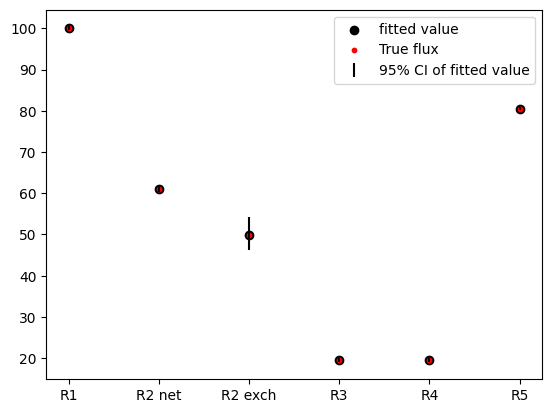

In [13]:
fig, ax = plt.subplots()
errbars = estimated_fluxes[['lb', 'ub']].subtract(estimated_fluxes['val'], axis=0).abs().T
ax.errorbar(x=estimated_fluxes['id'], y=estimated_fluxes['val'], yerr=errbars, color='black', fmt='none', label='95% CI of fitted value')
ax.scatter(x=estimated_fluxes['id'], y=estimated_fluxes['val'], color='black', label='fitted value')
ax.scatter(x=true_fluxes['rxn_id'], y=true_fluxes['flux'], color='red', label='True flux', s=10)
ax.legend()

We see that INCAWrapper and INCA was able to obtain unbiased estimates of the true fluxes using INST 13C-MFA. The R2 exchange flux still has some uncertainty, but it is common for exchange fluxes not to be well determined [3]. Lets also inspect the numerical values of the fitted and true fluxes.

In [19]:
fitted_and_true_fluxes = (
    estimated_fluxes
    .merge(true_fluxes, left_on="id", right_on="rxn_id")
    .rename(columns={"val": "fitted_flux", "flux": "true_flux"})
)
fitted_and_true_fluxes[['type', 'id', 'eqn', 'true_flux', 'fitted_flux', 'std', 'lb', 'ub']].round(3)

,type,id,eqn,true_flux,fitted_flux,std,lb,ub
0,Net flux,R1,A -> B,100.000,99.992,0.190,99.51167,100.479345
1,Net flux,R2 net,B <-> D,61.132,61.151,0.299,60.342355,61.896734
2,Exch flux,R2 exch,B <-> D,49.806,49.849,1.736,46.264288,54.217439
3,Net flux,R3,B -> C + E,19.434,19.421,0.189,18.938698,19.950753
4,Net flux,R4,B + C -> D + E + E,19.434,19.421,0.189,18.938698,19.950753
5,Net flux,R5,D -> F,80.566,80.571,0.164,80.16627,80.97421


Again here we see that the incawrapper (and INCA) finds a good estimate of the true flux distribution.

## References
[1] M. R. Antoniewicz, J. K. Kelleher, and G. Stephanopoulos, “Determination of confidence intervals of metabolic fluxes estimated from stable isotope measurements,” Metabolic Engineering, vol. 8, no. 4, pp. 324–337, Jul. 2006, doi: 10.1016/j.ymben.2006.01.004.

[2] M. R. Antoniewicz, J. K. Kelleher, and G. Stephanopoulos, “Elementary metabolite units (EMU): A novel framework for modeling isotopic distributions,” Metabolic Engineering, vol. 9, no. 1, pp. 68–86, Jan. 2007, doi: 10.1016/j.ymben.2006.09.001.

[3] W. Wiechert and K. Nöh, “Quantitative Metabolic Flux Analysis Based on Isotope Labeling,” in Metabolic Engineering, 1st ed., J. Nielsen, G. Stephanopoulos, and S. Y. Lee, Eds., Wiley, 2021, pp. 73–136. doi: 10.1002/9783527823468.ch3.

